[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sagar87/scPCA/blob/main/docs/notebooks/kang.ipynb)

<div class="admonition note"> 
    <p class="admonition-title">Note</p>
    <p>In order to run this notebook in Google Colab run the following cells. For best performance make sure that you run the notebook on a GPU instance, i.e. choose from the menu bar Runtime > Change Runtime > Hardware accelerator > GPU.</p> 
</div>

In [3]:
# Install scPCA + dependencies
!pip install --quiet scpca scikit-misc

In [2]:
# Download the Kang et. al. dataset
!wget https://www.huber.embl.de/users/harald/scpca/angelidis.h5ad /content/angelidis.h5ad

# Analysing the brain cells in light stimulated mice

In this notebook, we analyse the dataset from Angelidis et. al. in which the authors investigated lung cells of aging mice.

In [54]:
import scpca as scp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

## Data preprocessing

We begin by importing the dataset with `scanpy`.

In [57]:
data_path = '/content/hrvatin.h5ad'
adata = sc.read_h5ad(data_path)

In [58]:
adata

AnnData object with n_obs × n_vars = 14745 × 20908
    obs: 'barcode', 'mouse_id', 'age', 'cell_type', 'cell_id'
    uns: 'X_name', 'celltype_column', 'condition_column', 'main_assay'

Examining the obs field of the `adata` object reveals that the dataset includes two conditions (`age` column), corresponding to mice aged 3 and 24 months.

In [4]:
adata.obs

barcode mouse_id  age           cell_type  \
muc3838:GCACTTTAGAAT  GCACTTTAGAAT  muc3838  24m      Ciliated_cells   
muc3838:TCCTGCTCCCTT  TCCTGCTCCCTT  muc3838  24m      Ciliated_cells   
muc3838:TCCTGCTCCCTG  TCCTGCTCCCTG  muc3838  24m      Ciliated_cells   
muc3838:TGCGAGTCTTCT  TGCGAGTCTTCT  muc3838  24m      Ciliated_cells   
muc3838:TCCTGCTCCCTC  TCCTGCTCCCTC  muc3838  24m      Ciliated_cells   
...                            ...      ...  ...                 ...   
muc4657:ATCAAGACAGTG  ATCAAGACAGTG  muc4657   3m  Type_2_pneumocytes   
muc4657:GACTGCGCATGG  GACTGCGCATGG  muc4657   3m      Ciliated_cells   
muc4657:ATGACCGAATGT  ATGACCGAATGT  muc4657   3m  Type_2_pneumocytes   
muc4657:GTGTTTGGACCG  GTGTTTGGACCG  muc4657   3m        Cd4+_T_cells   
muc4657:TGGCCGTGTAGC  TGGCCGTGTAGC  muc4657   3m        Goblet_cells   

                                   cell_id  
muc3838:GCACTTTAGAAT  muc3838:GCACTTTAGAAT  
muc3838:TCCTGCTCCCTT  muc3838:TCCTGCTCCCTT  
muc3838:TCCTGCTCCCTG  muc3838:TCCTGCTCCCTG  
muc3838:TGCGAGTCTTCT  muc3838:TGCGAGTCTTCT  
muc3838:TCCTGCTCCCTC  muc3838:TCCTGCTCCCTC  
...                                    ...  
muc4657:ATCAAGACAGTG  muc4657:ATCAAGACAGTG  
muc4657:GACTGCGCATGG  muc4657:GACTGCGCATGG  
muc4657:ATGACCGAATGT  muc4657:ATGACCGAATGT  
muc4657:GTGTTTGGACCG  muc4657:GTGTTTGGACCG  
muc4657:TGGCCGTGTAGC  muc4657:TGGCCGTGTAGC  

[14745 rows x 5 columns]

Before proceeding with the selection of highly variable genes, we filter out low-quality cells and red blood cells, as the latter are not representative of lung cell types.

In [5]:
adata = adata[~adata.obs['cell_type'].isin(['low_quality_cells', 'red_blood_cells'])]

In [6]:
adata.layers["counts"] = adata.X.copy()

/tmp/ipykernel_657/1517723426.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True,
    layer="counts"
)

## Factor analysis

Next, we model the data using scPCA. One strategy is to treat the 3-month condition as the reference and capture gene expression shifts in old mice as deviations from this baseline. This can be specified using the design formula `~ age`, similar to how one would define a model in a linear regression framework.

In [8]:
m0 = scp.scPCA(
    adata, 
    num_factors=10,
    layers_key='counts',
    loadings_formula='age',
    intercept_formula='1',
    seed=8999074
)

In [9]:
m0.fit()

  0%|          | 0/5000 [00:00<?, ?it/s]/g/huber/users/voehring/conda/scpca_dev/lib/python3.12/site-packages/scpca/models/scpca.py:68: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  α_rna = deterministic("α_rna", (1 / α_rna_inv).T)
Epoch: 4990 | lr: 1.00E-02 | ELBO: 2913242 | Δ_10: 43149.50 | Best: 2838556: 100%|██████████| 5000/5000 [02:12<00:00, 37.65it/s]   


In [10]:
m0.fit(lr=0.001, num_epochs=10000)

Epoch: 14990 | lr: 1.00E-03 | ELBO: 2876858 | Δ_10: 37865.50 | Best: 2809824: 100%|██████████| 10000/10000 [04:08<00:00, 40.29it/s]


Let's store the result from the factorisation in the `adata` object.

In [11]:
m0.mean_to_anndata(model_key='m0', num_samples=10, num_split=512)

Predicting z for obs 13824-14065.: 100%|██████████| 28/28 [00:02<00:00, 13.78it/s]


If we now take a close look at the adata object we will find that the factors and loadings were added to the `obsm` and `varm` fields respectively (`X_m0` and `W_m0`). Meta data related to the model field are stored under `adata.uns[{model_key}]`.

In [12]:
adata

AnnData object with n_obs × n_vars = 14066 × 2000
    obs: 'barcode', 'mouse_id', 'age', 'cell_type', 'cell_id'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'celltype_column', 'condition_column', 'main_assay', 'hvg', 'm0'
    obsm: 'X_m0'
    varm: 'W_m0'
    layers: 'counts'

Let's check our factor representation by getting a visual overview using UMAP. We use the UMAP helper function of scpca to accomplish that.

In [13]:
scp.tl.umap(adata, 'X_m0')

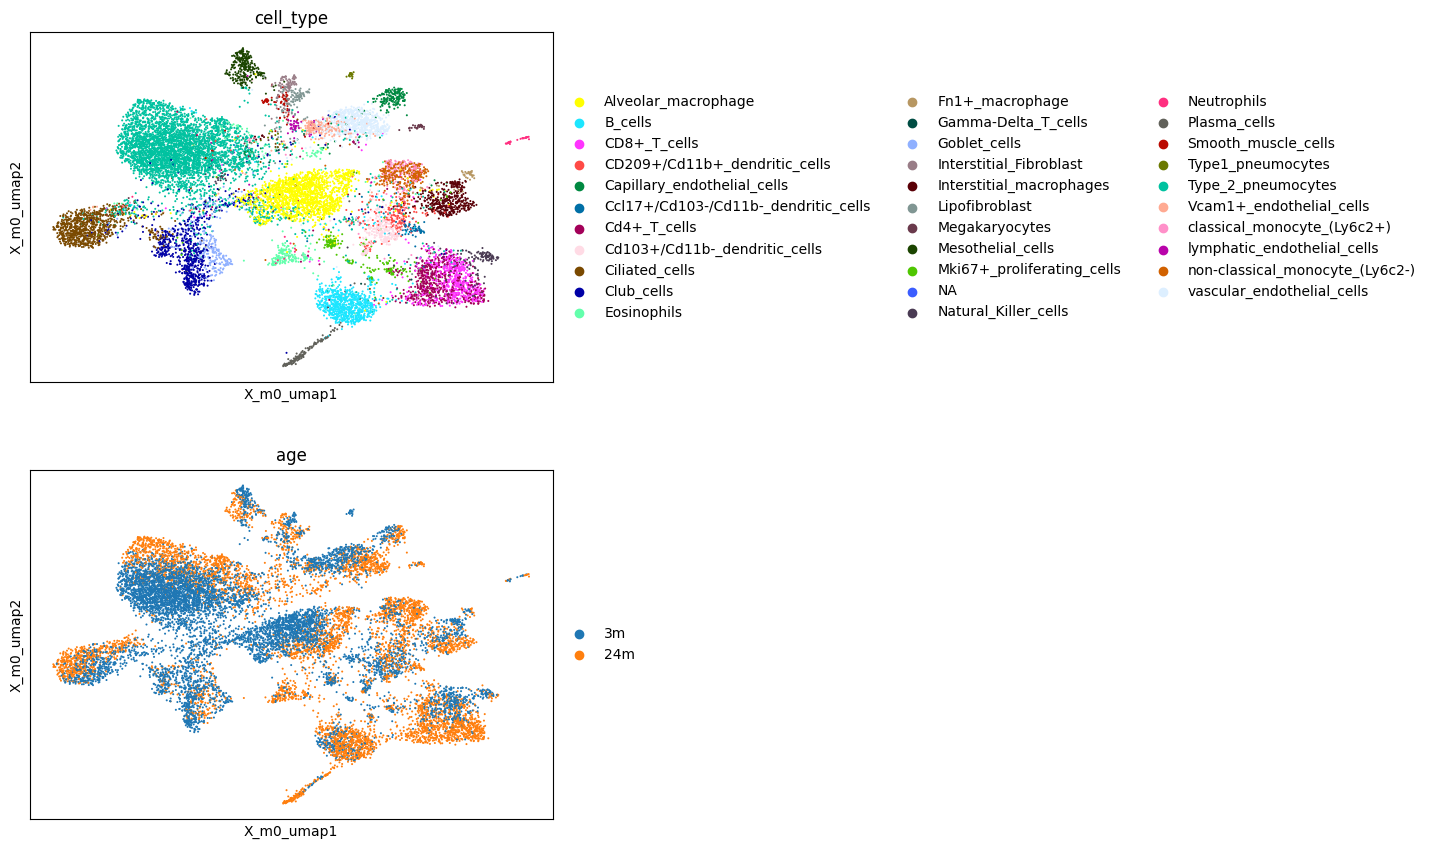

In [14]:
sc.pl.embedding(adata, basis='X_m0_umap', color=['cell_type', 'age'], ncols=1)

We now try to assess the main factors of the decomposition.

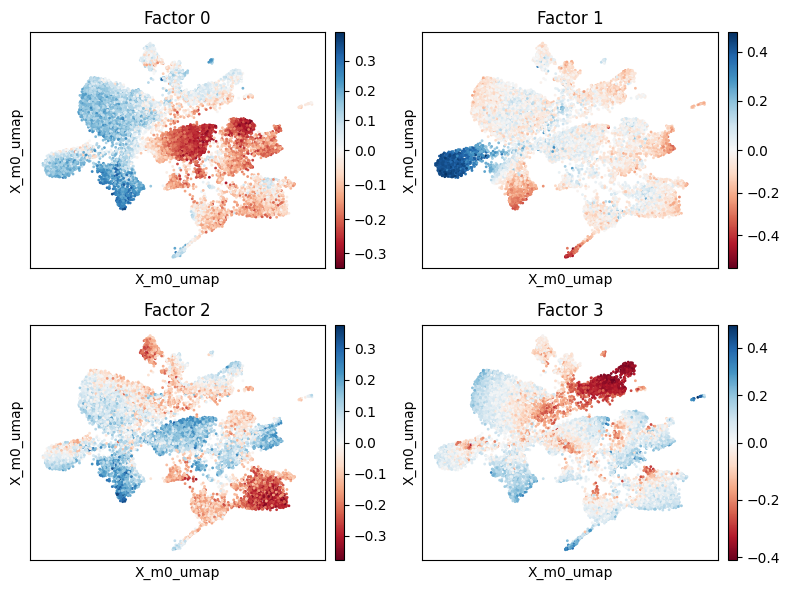

In [15]:
scp.pl.factor_embedding(adata, model_key='m0', factor=[0, 1, 2, 3], basis='X_m0_umap', ncols=2)
plt.tight_layout()

### Factor 0

We begin by examining factor 0 more closely. This factor displays notably negative weights in myeloid cells, including alveolar macrophages and monocytes, and positive weights in club and goblet cells.

<Axes: title={'center': 'Factor 0'}, xlabel='cluster', ylabel='Factor weight'>

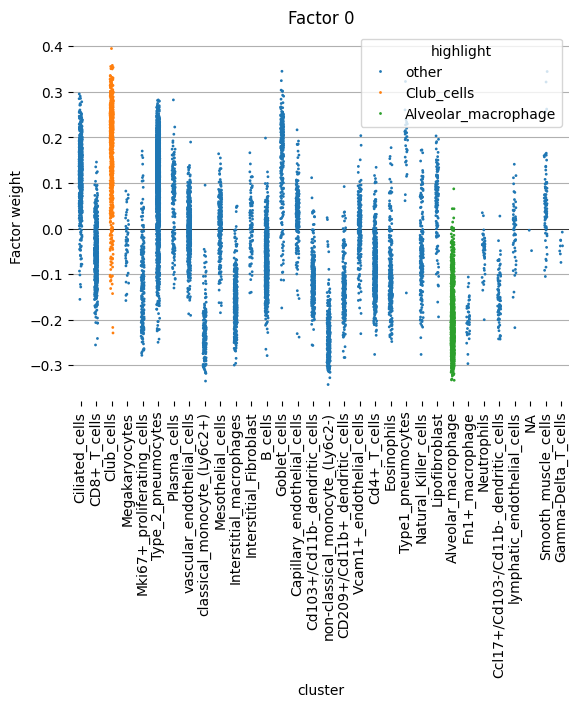

In [26]:
scp.pl.factor_strip(adata, model_key='m0', factor=[0], cluster_key='cell_type', highlight=['Alveolar_macrophage', 'Club_cells'], s=2)

Next we take a close look at the _negative_ loading weights of factor 0 to learn more about the expression patterns in the myeloid cells of this dataset. We can extract those from the `adata` object using the `state_loadings` function. Since the factor weights are negative for the myeloid cells, we use the argument `lowest=20` and `highest=0` to extract the genes with the largest negative loading weights.

In [34]:
top_weights_fac0 = scp.tl.state_loadings(adata, 'm0', 'Intercept', 0, highest=0, lowest=20)

In [35]:
top_weights_fac0

gene  magnitude     weight    type  state  factor  index
0           Abcg1   8.844831  -8.844831  lowest      0       0     73
1         Bcl2a1a   8.854088  -8.854088  lowest      0       0    162
2           Mpeg1   9.212790  -9.212790  lowest      0       0   1053
3           Marco   9.213015  -9.213015  lowest      0       0   1020
4   1100001G20Rik   9.315811  -9.315811  lowest      0       0      0
5        Atp6v0d2   9.373060  -9.373060  lowest      0       0    144
6           Ltc4s   9.418015  -9.418015  lowest      0       0    994
7           Fabp1   9.497688  -9.497688  lowest      0       0    542
8          Clec4n   9.505602  -9.505602  lowest      0       0    368
9            Mrc1   9.583654  -9.583654  lowest      0       0   1055
10           Ear1   9.637006  -9.637006  lowest      0       0    496
11        Bcl2a1d   9.889424  -9.889424  lowest      0       0    164
12        Clec4a3  10.041142 -10.041142  lowest      0       0    363
13         Fcer1g  10.077384 -10.077384  lowest      0       0    573
14         Tyrobp  10.141203 -10.141203  lowest      0       0   1513
15           Cybb  10.273161 -10.273161  lowest      0       0    435
16           Ccl6  10.514906 -10.514906  lowest      0       0    252
17         Chi3l3  10.604345 -10.604345  lowest      0       0    340
18           Ear2  10.699730 -10.699730  lowest      0       0    498
19           Ctss  10.881914 -10.881914  lowest      0       0    420

As expected the genes are largely associated with myeloid cells, particularly macrophages, and more specifically, alveolar macrophages or monocyte-derived macrophages:

* Strong indicators of macrophages / myeloid lineage: Mpeg1, Clec4a3, Clec4n, Fcer1g, Tyrobp, Cybb, Ctss – general myeloid/macrophage markers.
* Marco, Mrc1 (CD206) – alveolar macrophage markers; Marco is specific to tissue-resident macrophages like alveolar macrophages.
* Chi3l3 (Ym1), Ear1, Ear2, Ccl6 – often upregulated in alternatively activated (M2-like) macrophages in mice.
* Bcl2a1a, Bcl2a1d – anti-apoptotic genes, enriched in immune cells including myeloid cells.
* Atp6v0d2 – involved in osteoclast/macrophage function.
* Ltc4s – leukotriene pathway, expressed in myeloid-derived cells.
* Abcg1 – involved in lipid homeostasis, enriched in alveolar macrophages.
* Tyrobp – adapter protein for many immune receptors, common in microglia/macrophages.

We next ask the question how the factor 0 changed across conditions. To this end we can compute the loading differences between factor 0 loading weigths between the 24m and 3m condition.

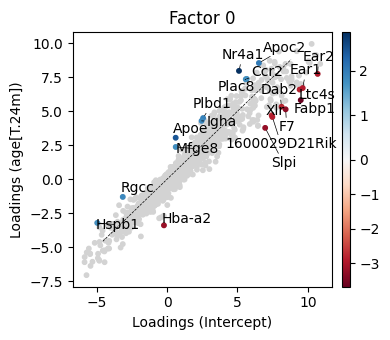

In [41]:
_ = scp.pl.loadings_state(adata, 'm0', ['Intercept', 'age[T.24m]'], 0, sign=-1, highest=10, lowest=10, width=4, height=3.5)
plt.tight_layout()

Interestingly we can see here see the downregulation of Ltc4s, Ear1, Ear2 – These are typically expressed in tissue-resident lung macrophages. Their downregulation suggests a  shift in macrophage state (e.g., toward a more pro-inflammatory phenotype or loss of identity).

The set of upregulated genes appears to reflect a shift in macrophage state—potentially toward a more inflammatory, monocyte-derived, or activated phenotype, possibly related to aging or stress in the lung environment. This is especially supported by the upregulation of:

* Nr4a1: Transcription factor critical for the development of non-classical monocytes; also involved in anti-inflammatory responses and macrophage self-renewal. Upregulation may indicate a monocyte-to-macrophage transition or stress adaptation.

* Apoe, Apoc2: Apolipoproteins associated with lipid metabolism and foam-cell–like macrophage states; commonly upregulated in aging, inflammation, or lipid-rich environments (e.g., alveolar space). These are known markers of activated macrophages in chronic inflammation and neurodegeneration, too.

### Factor 1

Next we look at factor 1. Factor 1 exhibits high factor values in Ciliated Cells. Let's also have a look factor 1s corresponding loading weights.

In [31]:
top_weights_fac1 = scp.tl.state_loadings(adata, 'm0', 'Intercept', 1, highest=20)

In [33]:
top_weights_fac1.head()

gene  magnitude    weight     type  state  factor  index
0        Fam183b   8.030411  8.030411  highest      0       1    554
1  1700016K19Rik   7.806339  7.806339  highest      0       1     15
2           Mlf1   7.700116  7.700116  highest      0       1   1041
3        Tmem212   7.574149  7.574149  highest      0       1   1443
4  1700024G13Rik   7.569454  7.569454  highest      0       1     17

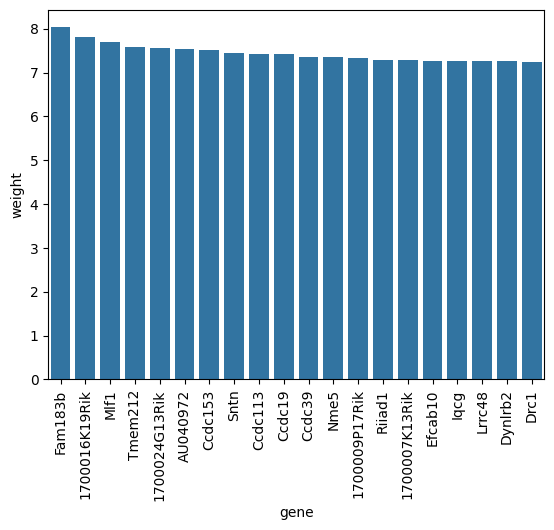

In [35]:
ax = sns.barplot(data=top_weights_fac1, x='gene', y='weight')
ax.tick_params(axis='x', rotation=90)

These genes—like _CCDC39_, _Drc1_, _Dynlrb2_, plus several coiled‑coil domain proteins (_CCDC113_, _CCDC153_, etc.)—are classic markers of motile cilia structures: they play key roles in axonemal assembly, dynein arm formation, and ciliary motility. For example, _CCDC39_ is essential for the dynein regulatory complex and inner dynein arms, and _DRC1_ also has a similar role in ciliary beat regulation.

We next ask the question how the factor 1 changed across conditions. To this end we can compute the loading differences between factor 1 loading weigths from the 24m and 3m condition.

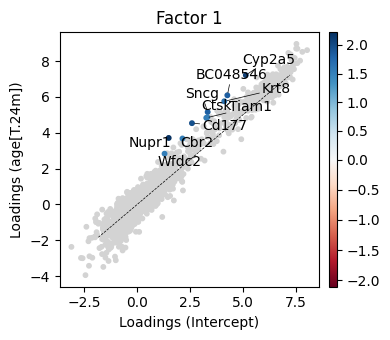

In [44]:
_ = scp.pl.loadings_state(adata, 'm0', ['Intercept', 'age[T.24m]'], 1, highest=10, width=4, height=3.5)
plt.tight_layout()

In [50]:
top_loading_diff_1 = scp.tl.state_diff(adata, 'm0',  ['Intercept', 'age[T.24m]'], 1, highest=20)

These genes, when considered collectively, point to a signature of metabolically active, detoxifying epithelial cells—possibly from liver or lung tissue. They combine:

* Detox enzymes and transporters (P450s, Sult1d1, Slc16a11)
* Epithelial structural/barrier proteins (Krt8, Cldn3, WFDC2)
* Stress response and regulatory factors (Nupr1, Tiam1, Wif1, Dkkl1)


Together these results indicate that scPCAs inferred loading weight differences indicate that ciliated cells shift toward a more metabollically active / stress respond state in old mice. 